# Data pre processing

## Simple rate conversion

In [1]:
import librosa
from scipy.io import wavfile as wav
import numpy as np

In [2]:
file_name = 'samples/100852-0-0-0.wav'
librosa_audio, librosa_rate = librosa.load(file_name)
scipy_sample_rate, scipy_audio = wav.read(file_name)

print(f'Original sample rate: {scipy_sample_rate}')
print(f'Librosa sample rate: {librosa_rate}')

Original sample rate: 44100
Librosa sample rate: 22050


## Bit-depth

In [3]:
print(f'Original audio file min~max range: {np.min(scipy_audio)} to {np.max(scipy_audio)}')
print(f'Librosa audio file min~max range: {np.min(librosa_audio)} to {np.max(librosa_audio)}')

Original audio file min~max range: -23628 to 27507
Librosa audio file min~max range: -0.5026644468307495 to 0.7498393654823303


## Merging auddio channels

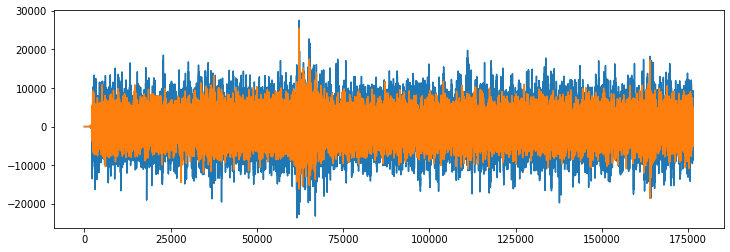

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

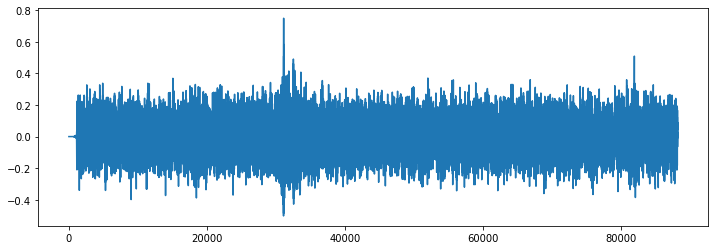

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

# Extract features

## Mel-frequency Cepstral Coefficients (MFCC)

In [6]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


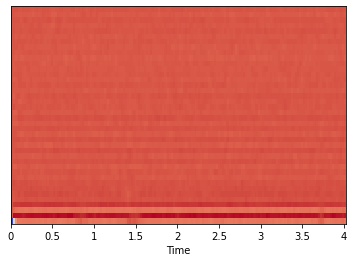

In [7]:
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_rate, x_axis='time')

# Extract MFCC for the DS

In [8]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccscaledd = np.mean(mfcc.T, axis=0)
    except Exception as e:
        print(f'Error processing: {file_name} - {e}')
        mfccscaledd = None
    return mfccscaledd

In [9]:
import pandas as pd
import os
from tqdm import tqdm

In [10]:
full_dataset_path = 'Data/UrbanSound8K/audio'
metadata = pd.read_csv('Data/UrbanSound8K/metadata/UrbanSound8K.csv')
features = []

In [11]:
for idx, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(full_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))

    class_label = row['class']
    data = extract_features(file_name)

    features.append([data, class_label])
features_df = pd.DataFrame(features, columns=['feature', 'label'])
print(f'Finished features extraction from: {len(features_df)} files')

3555it [08:21,  7.76it/s]C:\Users\masterdoc\anaconda3\envs\DeepLearning\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8324it [18:46, 12.49it/s]C:\Users\masterdoc\anaconda3\envs\DeepLearning\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\masterdoc\anaconda3\envs\DeepLearning\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [19:36,  7.42it/s]

Finished features extraction from: 8732 files


In [12]:
features_df.head()

,feature,label
0,"[-209.93578, 63.42263, -123.69025, -60.0192, -...",dog_bark
1,"[-417.29105, 100.148506, -43.869255, 51.953114...",children_playing
2,"[-452.77457, 113.24303, -38.501553, 44.0628, 7...",children_playing
3,"[-406.86542, 92.06992, -25.97457, 43.714268, 1...",children_playing
4,"[-440.05148, 104.7528, -43.601677, 51.623074, ...",children_playing


# Convert the data and labels

In [13]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

### Convert the features and corresponding classification into numpy arrays

In [14]:
X = np.array(features_df.feature.tolist())
y = np.array(features_df.label.tolist())

### Encode the classification labels

In [15]:
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

## Split the data set

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state=42)

## Store the preprocessed data

In [17]:
%store x_train
%store x_test
%store y_train
%store y_test
%store yy
%store le

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'le' (LabelEncoder)


In [18]:
import pickle
pickle.dump(x_train, open('preprocessed/x_train.pkl', 'wb'))
pickle.dump(x_test, open('preprocessed/x_test.pkl', 'wb'))
pickle.dump(y_train, open('preprocessed/y_train.pkl', 'wb'))
pickle.dump(y_test, open('preprocessed/y_test.pkl', 'wb'))
pickle.dump(yy, open('preprocessed/yy.pkl', 'wb'))
pickle.dump(le, open('preprocessed/le.pkl', 'wb'))

# MLP

In [19]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [20]:
num_labels = yy.shape[1]

# Construct the modedl
model = Sequential()

model.add(Dense(256, input_shape=(40, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

## Compile the model

In [21]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Architecture

In [22]:
model.summary()

# Calculate pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print(f'Pre-training accuracy: {accuracy}%')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10496     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

## Training

In [23]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5',
                               verbose=1, save_best_only=True)
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

start = datetime.now()

model.fit(x_train,
          y_train,
          batch_size=num_batch_size,
          epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=[checkpointer, tensorboard_callback], verbose=1)

duration = datetime.now() - start
print(f'Training completed in time: {duration}')

Epoch 1/100
209/219 [===========================>..] - ETA: 0s - loss: 9.4599 - accuracy: 0.1799
Epoch 00001: val_loss improved from inf to 2.18295, saving model to saved_models\weights.best.basic_mlp.hdf5
219/219 [==============================] - 2s 5ms/step - loss: 9.1749 - accuracy: 0.1804 - val_loss: 2.1830 - val_accuracy: 0.1963
Epoch 2/100
212/219 [============================>.] - ETA: 0s - loss: 2.2827 - accuracy: 0.2260
Epoch 00002: val_loss improved from 2.18295 to 2.07456, saving model to saved_models\weights.best.basic_mlp.hdf5
219/219 [==============================] - 1s 5ms/step - loss: 2.2792 - accuracy: 0.2276 - val_loss: 2.0746 - val_accuracy: 0.2948
Epoch 3/100
219/219 [==============================] - ETA: 0s - loss: 2.0887 - accuracy: 0.2843
Epoch 00003: val_loss improved from 2.07456 to 1.86867, saving model to saved_models\weights.best.basic_mlp.hdf5
219/219 [==============================] - 1s 5ms/step - loss: 2.0887 - accuracy: 0.2843 - val_loss: 1.8687 - va

## Test model

In [24]:
import librosa
import numpy as np

In [25]:
def extract_feature(file_name):

    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None, None

    return np.array([mfccsscaled])

In [26]:
def print_prediction(file_name):
    prediction_feature = extract_feature(file_name)

    predicted_vector = model.predict(prediction_feature)
    classes_x = np.argmax(predicted_vector, axis=1)
    predicted_class = le.inverse_transform(classes_x)
    print("The predicted class is:", predicted_class[0], '\n')

    predicted_proba_vector = model.predict(prediction_feature)
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

## Valiation with samples

In [27]:
# Air conditioner
file_name = 'samples/100852-0-0-0.wav'
print_prediction(file_name)

The predicted class is: jackhammer 

air_conditioner 		 :  0.00014704343630000948905944824219
car_horn 		 :  0.00000000018031294513054518802164
children_playing 		 :  0.00000000000058626584489851474302
dog_bark 		 :  0.00000000000000475507906501034840
drilling 		 :  0.00000000638023989196767615794670
engine_idling 		 :  0.00000000000000058092425904500184
gun_shot 		 :  0.00000002642382845863266993546858
jackhammer 		 :  0.99985289573669433593750000000000
siren 		 :  0.00000000000008724242167449172691
street_music 		 :  0.00000000000595689339868976652781


In [28]:
# Drilling
file_name = 'samples/103199-4-0-0.wav'
print_prediction(file_name)

The predicted class is: drilling 

air_conditioner 		 :  0.00000012139321370341349393129349
car_horn 		 :  0.00032057994394563138484954833984
children_playing 		 :  0.00002209319791290909051895141602
dog_bark 		 :  0.00001540943776490166783332824707
drilling 		 :  0.80093646049499511718750000000000
engine_idling 		 :  0.00000020261408906208089319989085
gun_shot 		 :  0.00001884903940663207322359085083
jackhammer 		 :  0.09384891390800476074218750000000
siren 		 :  0.00000065670002413753536529839039
street_music 		 :  0.10483670979738235473632812500000


In [29]:
# Street music
file_name = 'samples/101848-9-0-0.wav'
print_prediction(file_name)

The predicted class is: street_music 

air_conditioner 		 :  0.00002023737761192023754119873047
car_horn 		 :  0.00020796226453967392444610595703
children_playing 		 :  0.00417005643248558044433593750000
dog_bark 		 :  0.00098126649390906095504760742188
drilling 		 :  0.00023795742890797555446624755859
engine_idling 		 :  0.00055792770581319928169250488281
gun_shot 		 :  0.00003463397661107592284679412842
jackhammer 		 :  0.00244212662801146507263183593750
siren 		 :  0.00001580975367687642574310302734
street_music 		 :  0.99133205413818359375000000000000


In [30]:
# Car horn
file_name = 'samples/100648-1-0-0.wav'
print_prediction(file_name)

The predicted class is: drilling 

air_conditioner 		 :  0.00000011366919494548710645176470
car_horn 		 :  0.00074678548844531178474426269531
children_playing 		 :  0.00001205801163450814783573150635
dog_bark 		 :  0.00001598868948349263519048690796
drilling 		 :  0.89092749357223510742187500000000
engine_idling 		 :  0.00000626955943516804836690425873
gun_shot 		 :  0.00000040306301229975360911339521
jackhammer 		 :  0.10819598287343978881835937500000
siren 		 :  0.00000109223776689759688451886177
street_music 		 :  0.00009378219692735001444816589355


# Save the model to deploy

In [31]:
from keras.models import model_from_json

In [33]:
# Serialize model to Json
model_json = model.to_json()
with open('models/mlp.json', 'w') as json_file:
    json_file.write(model_json)

In [34]:
# Serialize weights to HDF5
model.save_weights('models/mlp.h5')
print('Model saved')

Model saved


# Load the model and test it

In [35]:
json_file2 = open('models/mlp.json')
loaded_model_json = json_file2.read()
json_file2.close()

In [37]:
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights('models/mlp.h5')
print('Model loaded')

Model loaded


# Test the loaded model

In [38]:
file_name = 'samples/100648-1-0-0.wav'

In [39]:
prediction_feature = extract_feature(file_name)

predicted_vector = loaded_model.predict(prediction_feature)
classes_x = np.argmax(predicted_vector, axis=1)
predicted_class = le.inverse_transform(classes_x)
print("The predicted class is:", predicted_class[0], '\n')

predicted_proba_vector = loaded_model.predict(prediction_feature)
predicted_proba = predicted_proba_vector[0]
for i in range(len(predicted_proba)):
    category = le.inverse_transform(np.array([i]))
    print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

The predicted class is: drilling 

air_conditioner 		 :  0.00000011366919494548710645176470
car_horn 		 :  0.00074678548844531178474426269531
children_playing 		 :  0.00001205801163450814783573150635
dog_bark 		 :  0.00001598868948349263519048690796
drilling 		 :  0.89092749357223510742187500000000
engine_idling 		 :  0.00000626955943516804836690425873
gun_shot 		 :  0.00000040306301229975360911339521
jackhammer 		 :  0.10819598287343978881835937500000
siren 		 :  0.00000109223776689759688451886177
street_music 		 :  0.00009378219692735001444816589355
